In [1]:
# ! pip install catboost

In [2]:
# ! pip install shap

In [17]:
import os
import cv2
import shutil
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.callbacks import Callback
from keras.layers import Layer
from keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool

import shap
shap.initjs()

IMG_SIZE = 32,32
BATCH_SIZE = 16
SEED = 55
AUTO = tf.data.AUTOTUNE

In [4]:
#Creating new directory for full images
#os.mkdir('/content/drive/MyDrive/COM6003/program/full_images')

In [6]:
## Moving all images to new directory

# def move_to_images(path, dest_dir):
#     images = sorted(os.listdir(path))
#     for i in images:
#         try:
#             shutil.move(os.path.join(path, i), dest_dir)
#         except OSError:
#             pass


# move_to_images('/content/drive/MyDrive/COM6003/program/archive/imgs_part_1/imgs_part_1', '/content/drive/MyDrive/COM6003/program/full_images')
# move_to_images('/content/drive/MyDrive/COM6003/program/archive/imgs_part_2/imgs_part_2', '/content/drive/MyDrive/COM6003/program/full_images')
# move_to_images('/content/drive/MyDrive/COM6003/program/archive/imgs_part_3/imgs_part_3', '/content/drive/MyDrive/COM6003/program/full_images')

In [2]:
# Reading metadata file
data = pd.read_csv('G:\\HSUHK\\COM6003\\project\\archive\\metadata.csv')
data.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,PAT_684_1302_588.png,True


In [3]:
data['full_link'] = 'G:\\HSUHK\\COM6003\\project\\archive\\imgs\\' + data['img_id']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [5]:
# look-up table
# diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

# a function for encoding classes
# def create_class(X):
#     if X == 'BCC':
#         return 0
#     elif X =='ACK':
#         return 1
#     elif X == 'NEV':
#         return 2
#     elif X == 'SEK':
#         return 3
#     elif X == 'SCC':
#         return 4
#     elif X == 'MEL':
#         return 5
#     else:
#         print('error class')

# def create_class(X):
#     if X == 'BCC' or 'MEL' or 'SCC':
#         return 1
#     else:
#         return 0



# applying the function and dropped 'diagnostic' feature because of this can lead to overfit (the target leakage problem)

data['encoded_class'] = np.where(data['diagnostic'].isin(['BCC','MEL','SCC']),1,0)
data.drop(['diagnostic'], axis = 1, inplace = True)
data.sort_values(by ='patient_id', ascending = True, inplace = True, ignore_index = True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [7]:
# dropped all features contain null element and 'biopsed' feature

data.drop([ 'biopsed','patient_id', 'img_id','lesion_id','smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history',
         'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2'], axis = 1, inplace = True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            2298 non-null   int64 
 1   region         2298 non-null   object
 2   itch           2298 non-null   object
 3   grew           2298 non-null   object
 4   hurt           2298 non-null   object
 5   changed        2298 non-null   object
 6   bleed          2298 non-null   object
 7   elevation      2298 non-null   object
 8   full_link      2298 non-null   object
 9   encoded_class  2298 non-null   int32 
dtypes: int32(1), int64(1), object(8)
memory usage: 170.7+ KB


age：此列包含代表患者年龄的整数值。

region：此列包含指示皮肤病变所在身体区域的分类值。

itch：此列包含指示患者是否经历与皮肤病变相关的瘙痒的分类值。

grew：此列包含指示皮肤病变大小是否随着时间的推移而增大的分类值。

hurt：此列包含指示皮肤病变是否导致患者疼痛的分类值。

changed：此列包含指示皮肤病变的外观是否随时间变化的分类值。

bleed：此列包含指示皮肤病变是否出血的分类值。

elevation：此列包含指示皮肤病变是否高于皮肤表面的分类值。

full_link：此列包含表示皮肤病变图像完整链接的对象值。

encoded_class：此列包含表示皮肤病变的编码类别的整数值。编码基于皮肤癌的类型，例如黑色素瘤、基底细胞癌等。

In [9]:
train_data = data[:2000]
test_data = data[2000:]
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)

print('train  ->', train_data.shape)
print('test  ->', test_data.shape)

train  -> (2000, 10)
test  -> (298, 10)


In [10]:
counts = np.bincount(train_data['encoded_class'])

# weight_for_0 = 1.0 / counts[0]
# weight_for_1 = 1.0 / counts[1]
# weight_for_2 = 1.0 / counts[2]
# weight_for_3 = 1.0 / counts[3]
# weight_for_4 = 1.0 / counts[4]
# weight_for_5 = 1.0 / counts[5]

# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5}

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.0008984725965858042, 1: 0.0011273957158962795}

In [11]:
data['encoded_class'].value_counts()

encoded_class
0    1209
1    1089
Name: count, dtype: int64

In [12]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size

        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)

        return X


    def get_config(self):
        base_config = super().get_config()

        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

In [18]:
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
# X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
# X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
# X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
# X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
# X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)

X = GlobalAveragePooling2D(name = 'the_last_pooling_layer')(X)

out = Dense(6, activation = 'softmax')(X)


model = Model(inputs = inp, outputs = out)
model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ] )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 256)       3328      
                                                                 
 activation_9 (Activation)   (None, 16, 16, 256)       0         
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 256)      1024      
 chNormalization)                                                
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 16, 16, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 16, 16, 256)      7449

In [19]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


# Basic data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    return img, label

In [20]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_link'], train_data['encoded_class']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(BATCH_SIZE*10)
                 .prefetch(AUTO))

# Train dataset without shuffle and augmentation
train_loader_for_feature = tf.data.Dataset.from_tensor_slices((train_data['full_link'], train_data['encoded_class']))
train_dataset_for_feature = (train_loader_for_feature
                             .map(img_preprocessing, num_parallel_calls = AUTO)
                             .batch(BATCH_SIZE)
                             .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_link'], test_data['encoded_class']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [21]:
# Training feature extraction model and saved
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 75, class_weight = class_weight, verbose = 0)
model.save("convmixer_feature_extractor.h5")

# load model

In [61]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.preprocessing import image
import numpy as np

path_to_class_map = dict(zip(test_data['full_link'], test_data['encoded_class']))
# class_indices = {0: 'BCC', 1: 'ACK', 2: 'NEV', 3: 'SEK', 4: 'SCC', 5: 'MEL'}
class_indices = {0: 'Not Skin Cancer', 1: 'Skin Cancer'}

with custom_object_scope({'ConvMixerBlock': ConvMixerBlock}):
    model = load_model('convmixer_feature_extractor.h5')

def prepare_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)  # 加载图片并调整大小
    img_array = image.img_to_array(img)  # 将图片转换为numpy数组
    img_array = np.expand_dims(img_array, axis=0)  # 添加一个维度，因为模型期待的是批量的数据
    img_array /= 255.0  # 归一化到[0,1]
    return img_array


results_list = []
for img_path in test_data['full_link']:
    if img_path.lower().endswith(('.png')):
        prepared_img = prepare_image(img_path, target_size=(32, 32))
        predictions = model.predict(prepared_img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_name = class_indices[predicted_class_index]

        actual_class_index = path_to_class_map[img_path]
        actual_class_name = class_indices.get(actual_class_index, "Unknown")

        # 将结果作为字典添加到列表中
        results_list.append({
            'File': img_path.split('/')[-1],  # 提取文件名
            'Predicted': predicted_class_name,
            'Actual': actual_class_name
        })

# 在循环结束后，将列表转换为 DataFrame
results_df = pd.DataFrame(results_list)

1/1 [==============================] - 0s 34ms/step


In [62]:
results_df

,File,Predicted,Actual
0,G:\HSUHK\COM6003\project\archive\imgs\PAT_864_...,Not Skin Cancer,Skin Cancer
1,G:\HSUHK\COM6003\project\archive\imgs\PAT_851_...,Not Skin Cancer,Not Skin Cancer
2,G:\HSUHK\COM6003\project\archive\imgs\PAT_950_...,Skin Cancer,Skin Cancer
3,G:\HSUHK\COM6003\project\archive\imgs\PAT_83_1...,Skin Cancer,Skin Cancer
4,G:\HSUHK\COM6003\project\archive\imgs\PAT_976_...,Skin Cancer,Skin Cancer
...,...,...,...
293,G:\HSUHK\COM6003\project\archive\imgs\PAT_91_3...,Not Skin Cancer,Not Skin Cancer
294,G:\HSUHK\COM6003\project\archive\imgs\PAT_838_...,Not Skin Cancer,Skin Cancer
295,G:\HSUHK\COM6003\project\archive\imgs\PAT_835_...,Not Skin Cancer,Skin Cancer
296,G:\HSUHK\COM6003\project\archive\imgs\PAT_999_...,Not Skin Cancer,Not Skin Cancer


In [63]:
# results_df.to_csv('results.csv')

In [64]:
accuracy_by_class = results_df.groupby('Actual').apply(
    lambda x: (x['Predicted'] == x['Actual']).mean()
).reset_index(name='Accuracy')

print(accuracy_by_class)

            Actual  Accuracy
0  Not Skin Cancer  0.729167
1      Skin Cancer  0.495050


## 提取图片训练之后的结果

In [65]:
feature_extr = tf.keras.models.load_model('convmixer_feature_extractor.h5',
                                         custom_objects={"ConvMixerBlock": ConvMixerBlock })


# Feature extraction model
feature_extractor_model = Model(inputs=feature_extr.input, outputs=feature_extr.get_layer('the_last_pooling_layer').output)

In [66]:
pred = feature_extractor_model.predict(train_dataset_for_feature)

125/125 [==============================] - 4s 32ms/step


In [67]:
# Applying PCA 41 components nearly equal to 0.98 variance ratio

pca_ = PCA(41)
pred_pca = pca_.fit_transform(pred)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))

pred_pca = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with ConvMixer feature extractor
pred_pca.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,3.388135,0.567597,-2.356105,1.616161,-1.177493,1.155164,2.299041,-2.372282,-0.422264,-1.533176,...,-0.610809,-0.457158,0.274138,-0.033917,-0.085173,-0.014572,0.109274,0.244147,-0.129607,0.477117
1,-2.120733,-0.188917,1.500410,-0.009192,-0.040446,-3.195567,-2.715959,-0.477716,-2.550821,0.253424,...,-0.523861,0.412282,0.040763,-0.141259,-0.165983,0.108139,0.299779,0.556640,0.478086,-0.225604
2,-3.923066,-0.361049,-1.426975,0.605467,0.799074,1.158559,-1.023533,-0.126009,0.593864,0.641496,...,0.248551,0.163594,0.247678,0.058672,0.584146,0.186218,0.126848,-0.134984,0.206312,-0.319151
3,1.126855,-4.043877,1.444805,-1.354211,-0.283613,1.813228,-0.654787,1.247887,-1.023547,-0.834162,...,0.289998,-0.041833,-0.009338,0.066272,-0.397130,0.123731,0.070472,-0.355593,-0.162208,-0.428915
4,-2.206419,-1.659669,1.987074,1.946617,-0.380885,-0.327142,0.360667,-0.593716,0.508849,-0.560385,...,-0.608494,0.058508,-0.185568,-0.258191,0.036170,-0.598289,0.146548,-0.263151,0.233553,-0.018445


#### 将图像训练后的特征与文本数据结构，再使用分类器进行模型训练。

In [68]:
# Merging the deep learning features with meta data features

train_data_last = pd.concat([train_data, pred_pca], axis = 1)
train_data_last.drop(['full_link'], axis = 1, inplace = True)
train_data_last.head()

,age,region,itch,grew,hurt,changed,bleed,elevation,encoded_class,feature_1,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,69,ARM,TRUE,UNK,FALSE,UNK,FALSE,TRUE,1,3.388135,...,-0.610809,-0.457158,0.274138,-0.033917,-0.085173,-0.014572,0.109274,0.244147,-0.129607,0.477117
1,14,FACE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,-2.120733,...,-0.523861,0.412282,0.040763,-0.141259,-0.165983,0.108139,0.299779,0.556640,0.478086,-0.225604
2,14,FACE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,-3.923066,...,0.248551,0.163594,0.247678,0.058672,0.584146,0.186218,0.126848,-0.134984,0.206312,-0.319151
3,65,EAR,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,1.126855,...,0.289998,-0.041833,-0.009338,0.066272,-0.397130,0.123731,0.070472,-0.355593,-0.162208,-0.428915
4,63,FOREARM,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,0,-2.206419,...,-0.608494,0.058508,-0.185568,-0.258191,0.036170,-0.598289,0.146548,-0.263151,0.233553,-0.018445


**直接训练，不考虑数据不平衡问题，结果较差**

In [ ]:
# # Splitting features and target

# y_train_data_last = train_data_last.pop('encoded_class')
# X_train_data_last = train_data_last

# print('catboost train shape ->', X_train_data_last.shape)

catboost train shape -> (2000, 49)


In [ ]:
# # Creating train pool for the catboost model

# cat_features = ['region', 'itch', 'grew', 'hurt', 'changed','bleed', 'elevation']
# train_pool = Pool(X_train_data_last, y_train_data_last, cat_features = cat_features)

In [ ]:
# cat_model = CatBoostClassifier(verbose = 250)
# cat_model.fit(train_pool)

Learning rate set to 0.081974
0:	learn: 1.6657123	total: 219ms	remaining: 3m 38s
250:	learn: 0.3682119	total: 41.4s	remaining: 2m 3s
500:	learn: 0.1992334	total: 1m 19s	remaining: 1m 18s
750:	learn: 0.1247026	total: 1m 57s	remaining: 38.8s
999:	learn: 0.0833205	total: 2m 35s	remaining: 0us


**添加权重进行训练---结果与不添加权重一样，对数量较少的数据仍然不能较好的进行预测**

In [69]:
# 首先，根据每个样本的类别赋予它相应的权重
train_data_last['sample_weight'] = train_data_last['encoded_class'].map(class_weight)
cat_features = ['region', 'itch', 'grew', 'hurt', 'changed','bleed', 'elevation']

# 然后，创建 CatBoost 数据集
train_pool = Pool(data=train_data_last.drop(['encoded_class', 'sample_weight'], axis=1),
                  label=train_data_last['encoded_class'],
                  weight=train_data_last['sample_weight'],
                  cat_features = cat_features)

# 最后，训练 CatBoost 模型
cat_model = CatBoostClassifier(verbose = 250)
cat_model.fit(train_pool)

Learning rate set to 0.013851


0:	learn: 0.6821922	total: 46ms	remaining: 45.9s
250:	learn: 0.2076424	total: 12s	remaining: 35.9s
500:	learn: 0.1328208	total: 26s	remaining: 25.9s
750:	learn: 0.0904850	total: 39.2s	remaining: 13s
999:	learn: 0.0650867	total: 49.3s	remaining: 0us


In [70]:
train_data_last['encoded_class'].map(class_weight).value_counts()

encoded_class
0.000898    1113
0.001127     887
Name: count, dtype: int64

**对训练集进行上采样**

In [71]:
from imblearn.over_sampling import RandomOverSampler

# 定义随机上采样对象
ros = RandomOverSampler(random_state=42)

# 少数类过采样
X_ros, y_ros = ros.fit_resample(train_data_last.drop('encoded_class', axis=1), train_data_last['encoded_class'])

# 将上采样后的数据与原始数据合并
train_data_last = pd.concat([X_ros, y_ros.to_frame()], axis=1)
train_data_last.columns = train_data_last.drop('encoded_class', axis=1).columns.tolist() + ['encoded_class']

# 查看各类别的样本数量
train_data_last['encoded_class'].value_counts()

encoded_class
1    1113
0    1113
Name: count, dtype: int64

In [73]:
train_data_last

,age,region,itch,grew,hurt,changed,bleed,elevation,feature_1,feature_2,...,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,sample_weight,encoded_class
0,69,ARM,TRUE,UNK,FALSE,UNK,FALSE,TRUE,3.388135,0.567597,...,0.274138,-0.033917,-0.085173,-0.014572,0.109274,0.244147,-0.129607,0.477117,0.001127,1
1,14,FACE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,-2.120733,-0.188917,...,0.040763,-0.141259,-0.165983,0.108139,0.299779,0.556640,0.478086,-0.225604,0.000898,0
2,14,FACE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,-3.923066,-0.361049,...,0.247678,0.058672,0.584146,0.186218,0.126848,-0.134984,0.206312,-0.319151,0.000898,0
3,65,EAR,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,1.126855,-4.043877,...,-0.009338,0.066272,-0.397130,0.123731,0.070472,-0.355593,-0.162208,-0.428915,0.000898,0
4,63,FOREARM,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,-2.206419,-1.659669,...,-0.185568,-0.258191,0.036170,-0.598289,0.146548,-0.263151,0.233553,-0.018445,0.000898,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,85,FACE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,0.085355,1.551328,...,-0.264574,-0.096380,0.113535,-0.590624,0.217940,-0.119849,0.513092,-0.259027,0.001127,1
2222,64,CHEST,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,-0.849526,2.122082,...,0.094996,-0.193737,0.041893,0.055437,0.160208,-0.067995,0.326724,0.075233,0.001127,1
2223,72,ARM,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,-4.014273,-1.618098,...,0.109125,0.152888,0.284034,-0.137601,-0.010595,-0.093976,0.200466,0.041546,0.001127,1
2224,56,FOREARM,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,2.191025,3.206642,...,0.415205,-0.370719,0.040181,0.014456,0.261633,-0.200689,0.532463,-0.042170,0.001127,1


In [74]:
y_train_data_last = train_data_last['encoded_class']
X_train_data_last = train_data_last.drop(columns=['sample_weight','encoded_class'])
cat_features = ['region', 'itch', 'grew', 'hurt', 'changed','bleed', 'elevation']
train_pool = Pool(X_train_data_last, y_train_data_last, cat_features = cat_features)
cat_model = CatBoostClassifier(verbose = 250)
cat_model.fit(train_pool)

Learning rate set to 0.014499
0:	learn: 0.6836896	total: 62ms	remaining: 1m 1s
250:	learn: 0.2322255	total: 11.1s	remaining: 33s
500:	learn: 0.1532684	total: 21.8s	remaining: 21.7s
750:	learn: 0.1011945	total: 34.9s	remaining: 11.6s
999:	learn: 0.0702503	total: 44.2s	remaining: 0us


In [75]:
# Test set processing
# test feature exteaction -> applying PCA -> merging with metadata -> predictions of the catboost model

test_pred = feature_extractor_model.predict(test_dataset)

test_pred_pca = pca_.fit_transform(test_pred)
test_pred_pca = pd.DataFrame(test_pred_pca, columns = new_feature_column_names)

test_data_last = pd.concat([test_data, test_pred_pca], axis = 1)
test_data_last.drop(columns=['full_link'], axis = 1, inplace = True)

y_test_data_last = test_data_last.pop('encoded_class')
X_test_data_last = test_data_last


test_pool = Pool(X_test_data_last, y_test_data_last, cat_features = cat_features)
pred_cat_test = cat_model.predict(test_pool)


 5/19 [======>.......................] - ETA: 1s

19/19 [==============================] - 1s 33ms/step


In [76]:
pred_cat_test

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0], dtype=i

In [77]:
# Predictions and scores

mse = mean_squared_error(y_test_data_last, pred_cat_test)
acc = accuracy_score(y_test_data_last, pred_cat_test)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

Mean Squared Error : 0.26846
Accuracy Score : 73.15 %


In [79]:
diagnostic_classes = {0:'Not Skin Cancer', 1 : 'Skin Cancer'}

In [80]:
clf = classification_report(y_test_data_last, pred_cat_test, target_names = list(diagnostic_classes.values()))
print(clf)

                 precision    recall  f1-score   support

Not Skin Cancer       0.59      0.54      0.57        96
    Skin Cancer       0.79      0.82      0.81       202

       accuracy                           0.73       298
      macro avg       0.69      0.68      0.69       298
   weighted avg       0.73      0.73      0.73       298



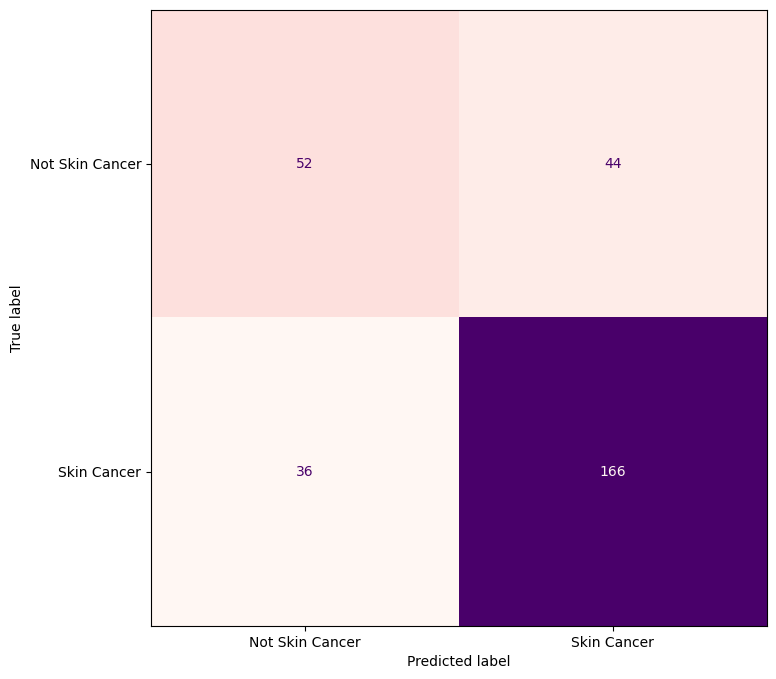

In [81]:
cm = confusion_matrix(y_test_data_last, pred_cat_test)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(diagnostic_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)

In [82]:
np.random.default_rng(seed=1).permutation(len(pred_cat_test))[:5]

array([166, 183,  23,   9, 121])

In [83]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred_cat_test))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)

        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()


        if int(pred_cat_test[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + diagnostic_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + diagnostic_classes[label], fontsize = 8, color = 'red')

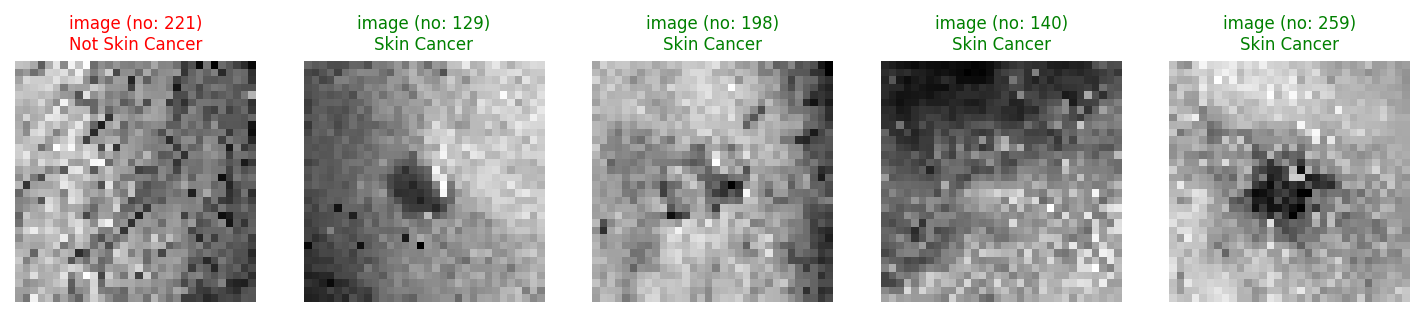

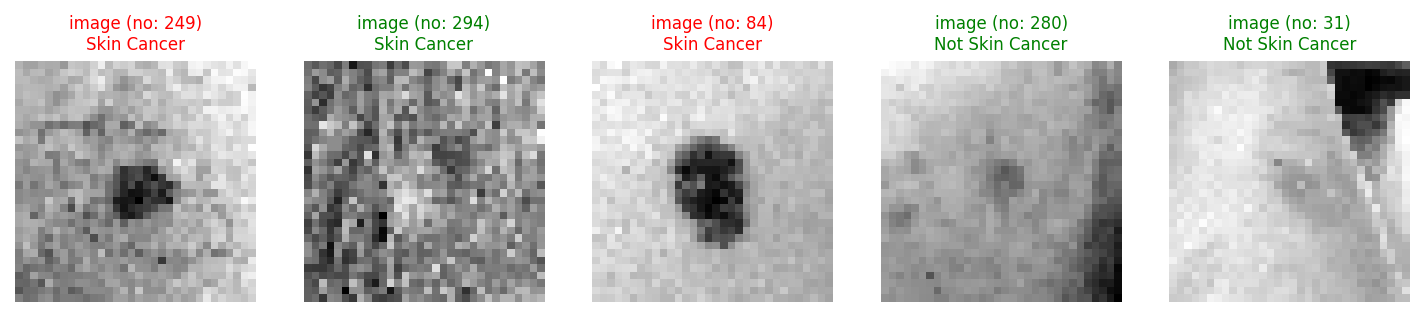

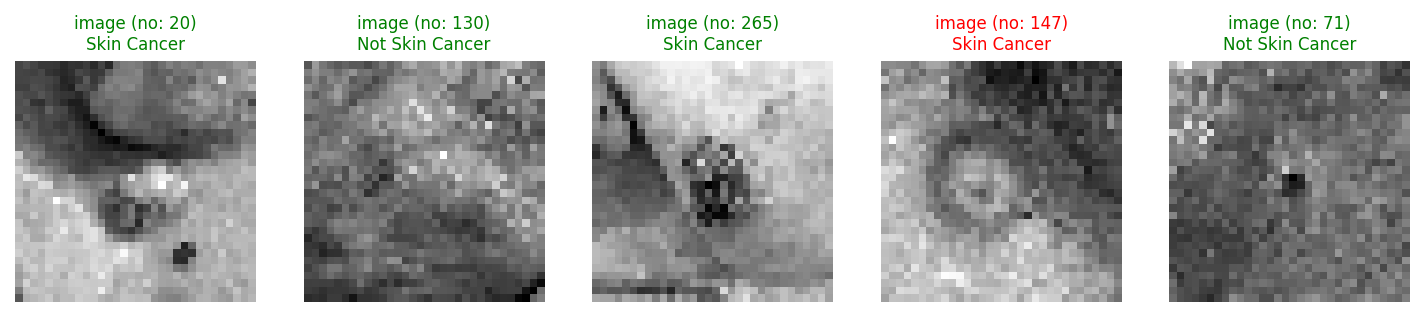

In [84]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 10)
random_test_sample_with_prediction(SEED = 20)
random_test_sample_with_prediction(SEED = 30)

In [85]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer(pd.DataFrame(X_test_data_last, columns = X_test_data_last.columns))

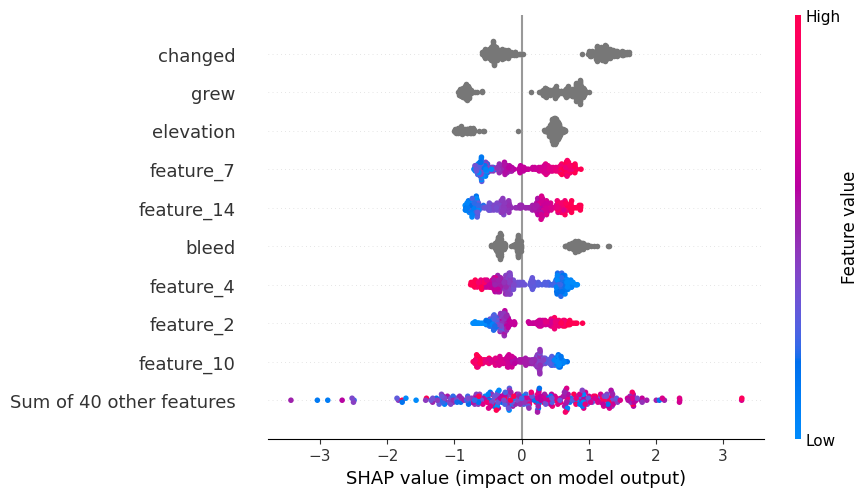

In [88]:
shap.plots.beeswarm(shap_values)


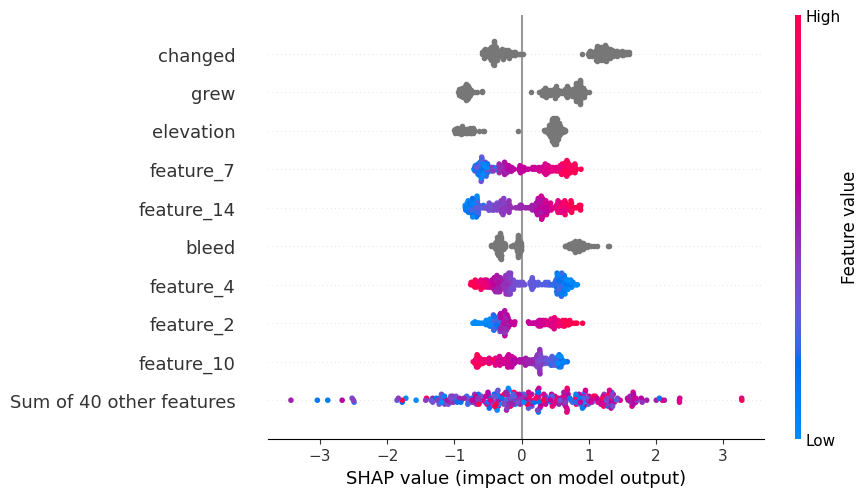

In [89]:
# ACK class feature explanation
shap.plots.beeswarm(shap_values)

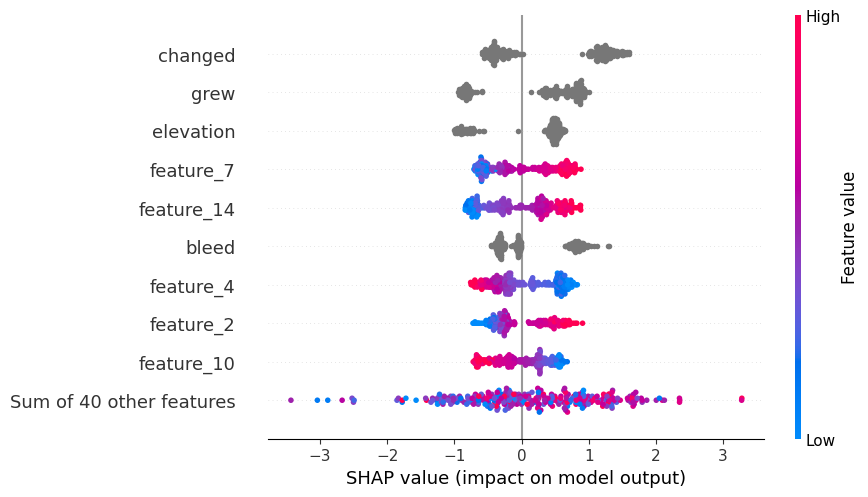

In [90]:
# NEV class feature explanation
shap.plots.beeswarm(shap_values)

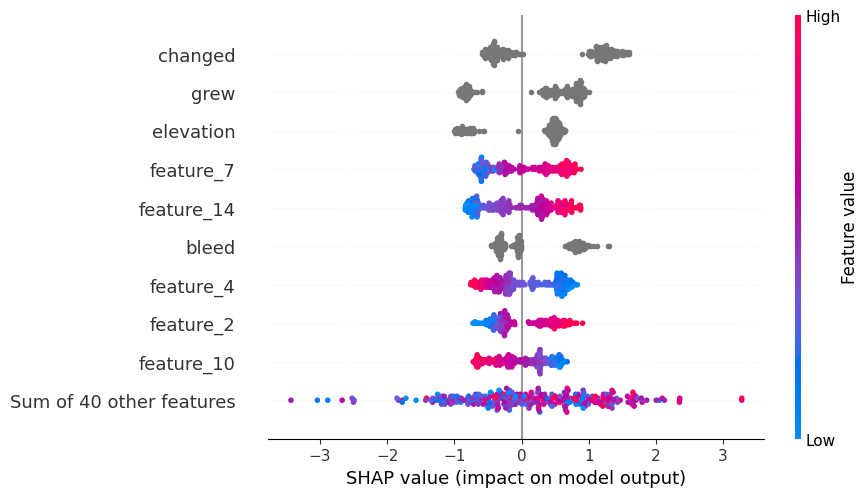

In [91]:
# SEK class feature explanation
shap.plots.beeswarm(shap_values)

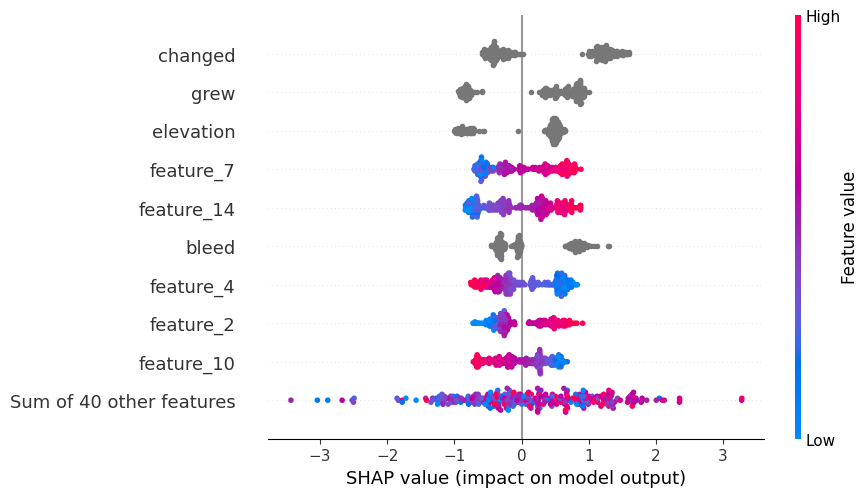

In [92]:
# SCC class feature explanation
shap.plots.beeswarm(shap_values)


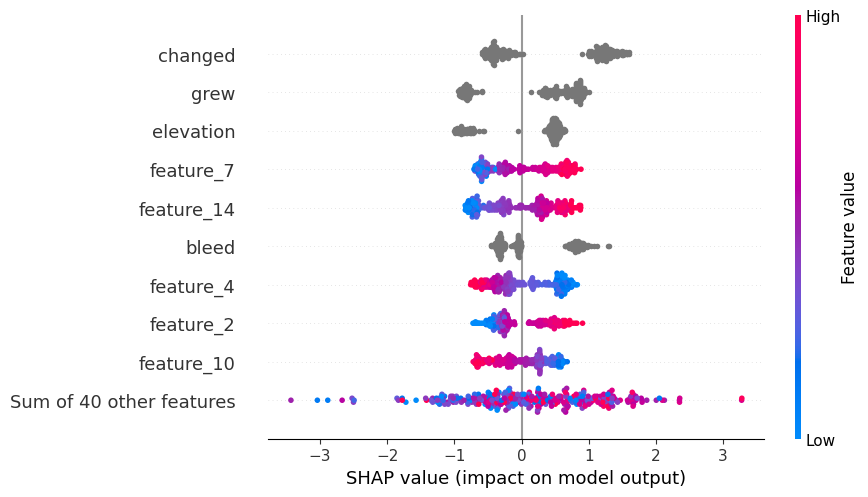

In [93]:
# MEL class feature explanation
shap.plots.beeswarm(shap_values)